In [1]:
# Importing the dependencies
import numpy as np
import pandas as pd
from xgboost import plot_importance, plot_tree
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"]
plt.style.use("tableau-colorblind10")

In [2]:
# Loading the dataset
df = pd.read_excel("/home/akash/Downloads/template_presage/test3.xlsx")
df.head()

,Date,hour,power,temperature,variable2
0,2017-02-01,00:00:00,44949.0,10.100000,65589
1,2017-02-01,01:00:00,44216.0,9.933333,61265
2,2017-02-01,02:00:00,43515.0,9.766667,60065
3,2017-02-01,03:00:00,43619.0,9.600000,57757
4,2017-02-01,04:00:00,44944.0,9.300000,55883


# EDA

In [3]:
# Lets see the shape of the dataset
df.shape

(1008, 5)

In [4]:
# Lets see the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1008 non-null   datetime64[ns]
 1   hour         1008 non-null   object        
 2   power        840 non-null    float64       
 3   temperature  1008 non-null   float64       
 4   variable2    1008 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 39.5+ KB


In [5]:
# null values
df.isnull().sum()

Date             0
hour             0
power          168
temperature      0
variable2        0
dtype: int64

In [6]:
df['power']=df['power'].replace(np.nan,df['power'].mean())

In [7]:
# Feature Extraction
df["Day"] = df["Date"].dt.day
df["hour"] = df["Date"].dt.hour
df["dayofweek"] = df["Date"].dt.dayofweek
df["quarter"] = df["Date"].dt.quarter
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year
df["dayofyear"] = df["Date"].dt.dayofyear
df["dayofmonth"] = df["Date"].dt.day
df["weekofyear"] = df["Date"].dt.weekofyear

/tmp/ipykernel_26496/1575396700.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["weekofyear"] = df["Date"].dt.weekofyear


In [8]:
# data
df.head()

,Date,hour,power,temperature,variable2,Day,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2017-02-01,0,44949.0,10.100000,65589,1,2,1,2,2017,32,1,5
1,2017-02-01,0,44216.0,9.933333,61265,1,2,1,2,2017,32,1,5
2,2017-02-01,0,43515.0,9.766667,60065,1,2,1,2,2017,32,1,5
3,2017-02-01,0,43619.0,9.600000,57757,1,2,1,2,2017,32,1,5
4,2017-02-01,0,44944.0,9.300000,55883,1,2,1,2,2017,32,1,5


In [9]:
# dropping the unwanted features
df = df.drop(['hour'], axis = 1)

In [10]:
df.head()

,Date,power,temperature,variable2,Day,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2017-02-01,44949.0,10.100000,65589,1,2,1,2,2017,32,1,5
1,2017-02-01,44216.0,9.933333,61265,1,2,1,2,2017,32,1,5
2,2017-02-01,43515.0,9.766667,60065,1,2,1,2,2017,32,1,5
3,2017-02-01,43619.0,9.600000,57757,1,2,1,2,2017,32,1,5
4,2017-02-01,44944.0,9.300000,55883,1,2,1,2,2017,32,1,5


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1008 non-null   datetime64[ns]
 1   power        1008 non-null   float64       
 2   temperature  1008 non-null   float64       
 3   variable2    1008 non-null   int64         
 4   Day          1008 non-null   int64         
 5   dayofweek    1008 non-null   int64         
 6   quarter      1008 non-null   int64         
 7   month        1008 non-null   int64         
 8   year         1008 non-null   int64         
 9   dayofyear    1008 non-null   int64         
 10  dayofmonth   1008 non-null   int64         
 11  weekofyear   1008 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(9)
memory usage: 94.6 KB


In [12]:
# Lets see the unique values in the feature "Day"
df["Day"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [13]:
# Train and test data
df_train = df[df["Day"] < 22]
df_test = df[df["Day"] >= 22]


In [14]:
df_train=df_train.drop(['Date'], axis=1)

In [15]:
df_test=df_test.drop(['Date'], axis=1)

# Train test split

In [16]:
X_train = df_train.drop(["power"], axis = 1)
y_train = df_train["power"]
X_test = df_test.drop(["power"], axis = 1)
y_test = df_test["power"]

In [17]:
# Lets see the shapes of the train and test data
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(840, 10) (168, 10)
(840,) (168,)


# Model Training

In [18]:

reg = xgb.XGBRegressor(objective = "reg:squarederror", n_estimators = 1000, learning_rate=1e-3, random_state=0)
reg.fit(X_train, y_train, verbose = True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [19]:
# Prediction
yhat = reg.predict(X_test)
print(yhat)

[33618.402 30118.396 30118.396 30118.396 30118.396 29885.225 29619.008
 32589.121 36265.793 38470.66  38678.598 38678.598 38987.816 38678.598
 36287.53  34870.99  34870.99  33483.008 33618.402 39548.445 38987.816
 33618.402 32689.84  31520.055 31520.055 28750.406 28750.406 28750.406
 28750.406 28750.406 28750.406 28816.01  36353.426 37950.457 38987.816
 38987.816 38987.816 38678.598 36265.793 33618.402 33618.402 33618.402
 28816.01  39550.957 37950.457 28816.01  28582.93  28582.93  28476.16
 28476.16  28476.16  28476.16  28476.16  28476.16  28476.16  28476.16
 32963.85  36465.297 37805.8   37805.8   37950.457 37950.457 32472.781
 28816.01  28816.01  28582.93  28476.16  37661.902 34897.773 30016.63
 28476.16  32963.85  25265.477 24267.588 24267.588 24267.588 24267.588
 24267.588 24267.588 24267.588 24267.588 24267.588 24931.24  24267.588
 24267.588 24197.371 24109.322 24109.322 24109.322 24267.588 24267.588
 24267.588 24267.588 24267.588 24267.588 24267.588 24072.205 24072.205
 24072.20

In [20]:
len(yhat)

168

In [21]:
# Model Evaluation
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE: %f" %(rmse))

RMSE: 20022.555896


In [22]:
pd.DataFrame(yhat).to_excel("XgBoost result.xlsx", sheet_name="sheet_1")

In [23]:
result=pd.read_excel("/home/akash/XgBoost result.xlsx")
result

,Unnamed: 0,0
0,0,33618.402344
1,1,30118.396484
2,2,30118.396484
3,3,30118.396484
4,4,30118.396484
...,...,...
163,163,38996.863281
164,164,38996.863281
165,165,34897.773438
166,166,30016.630859


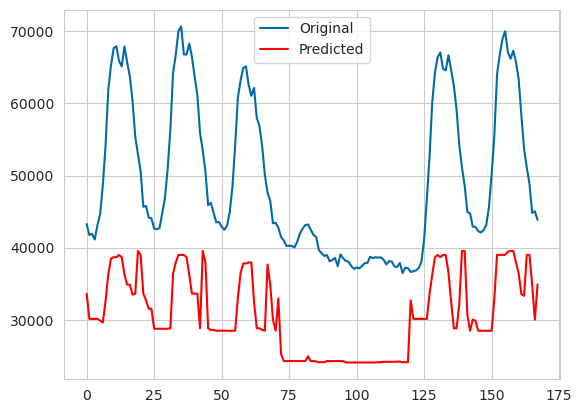

In [24]:
# Lets plot the actual vs predicted values
plt.plot(y_test.values, label = "Original")
plt.plot(yhat, label = "Predicted", color = "red")
plt.legend();

In [25]:
# Hyper parameter optimization
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)
gridcv_xgb = grid.best_estimator_
print(r2_score(y_test, gridcv_xgb.predict(X_test)))

0.6472141052699266


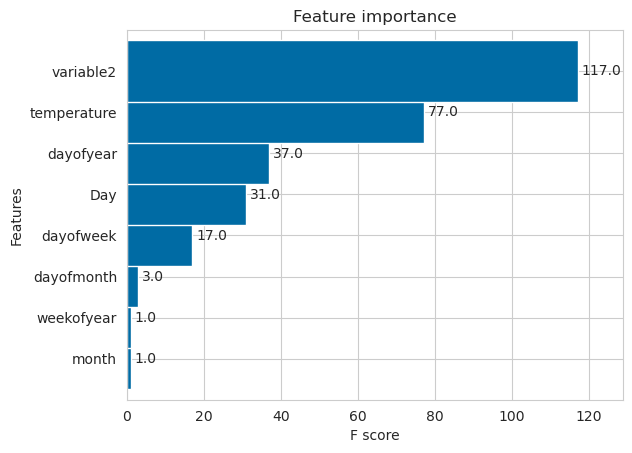

In [26]:
# Feature importance
_ = plot_importance(gridcv_xgb, height=1.5)

In [27]:
# Prediction
yhat1 = grid.predict(X_test)

In [28]:
yhat1

array([54956.195, 47825.44 , 47495.45 , 47495.45 , 47495.45 , 46171.824,
       45968.656, 53632.57 , 62002.35 , 64538.81 , 64422.5  , 61892.56 ,
       66750.38 , 64221.55 , 59104.3  , 58249.152, 55626.74 , 46967.016,
       54099.805, 66253.99 , 67319.78 , 56398.016, 50328.11 , 55074.39 ,
       55070.375, 48066.5  , 46167.81 , 43838.832, 43789.38 , 43789.38 ,
       43789.38 , 52691.945, 60832.734, 65992.15 , 65992.15 , 65992.15 ,
       67857.75 , 65247.75 , 60642.098, 55818.37 , 55494.168, 53334.918,
       55070.375, 67610.805, 63613.727, 52731.33 , 48009.46 , 52911.89 ,
       50603.082, 43752.145, 42113.523, 42123.855, 42123.855, 41647.883,
       41977.875, 50438.71 , 55761.94 , 59200.566, 61404.516, 62743.703,
       63613.727, 61254.957, 56398.05 , 52691.945, 50380.1  , 48130.23 ,
       50187.633, 60872.215, 57158.72 , 51281.082, 50425.934, 53511.266,
       45474.15 , 44055.395, 41896.145, 39081.05 , 37182.36 , 37182.36 ,
       39081.05 , 39519.8  , 42543.934, 43714.57 , 

In [29]:
# Evaluation
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE : % f" %(rmse))

RMSE :  20022.555896


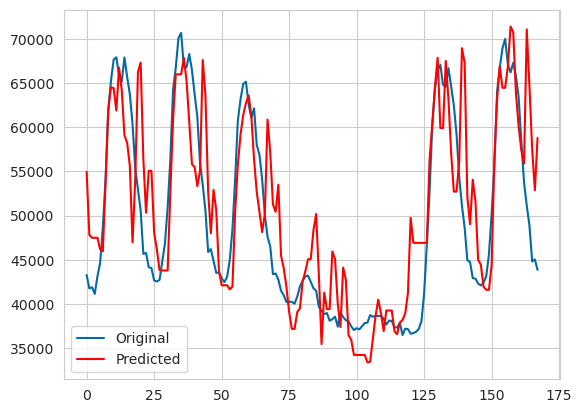

In [30]:

# Actual vs Predicted
plt.plot(y_test.values, label='Original')
plt.plot(yhat1, color='red', label='Predicted')
plt.legend();
     

In [31]:
y_test

504    43276.0
505    41760.0
506    41900.0
507    41138.0
508    43131.0
        ...   
667    51133.0
668    48887.0
669    44828.0
670    45039.0
671    43859.0
Name: power, Length: 168, dtype: float64

In [32]:
yhat1

array([54956.195, 47825.44 , 47495.45 , 47495.45 , 47495.45 , 46171.824,
       45968.656, 53632.57 , 62002.35 , 64538.81 , 64422.5  , 61892.56 ,
       66750.38 , 64221.55 , 59104.3  , 58249.152, 55626.74 , 46967.016,
       54099.805, 66253.99 , 67319.78 , 56398.016, 50328.11 , 55074.39 ,
       55070.375, 48066.5  , 46167.81 , 43838.832, 43789.38 , 43789.38 ,
       43789.38 , 52691.945, 60832.734, 65992.15 , 65992.15 , 65992.15 ,
       67857.75 , 65247.75 , 60642.098, 55818.37 , 55494.168, 53334.918,
       55070.375, 67610.805, 63613.727, 52731.33 , 48009.46 , 52911.89 ,
       50603.082, 43752.145, 42113.523, 42123.855, 42123.855, 41647.883,
       41977.875, 50438.71 , 55761.94 , 59200.566, 61404.516, 62743.703,
       63613.727, 61254.957, 56398.05 , 52691.945, 50380.1  , 48130.23 ,
       50187.633, 60872.215, 57158.72 , 51281.082, 50425.934, 53511.266,
       45474.15 , 44055.395, 41896.145, 39081.05 , 37182.36 , 37182.36 ,
       39081.05 , 39519.8  , 42543.934, 43714.57 , 

In [33]:
pd.DataFrame(yhat1).to_excel("Hyper_tuning output.xlsx", sheet_name="sheet 1")